In [62]:
import trino
import pandas as pd
import warnings
from datetime import datetime
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import pickle
import os 


# Set up DB connection
HOST = 'starburst.g8s-data-platform-prod.glovoint.com'
PORT = 443

conn_details = {
    'host': HOST,
    'port': PORT,
    'http_scheme': 'https',
    'auth': trino.auth.OAuth2Authentication()
}

In [63]:
def get_recurrent_customers_for_period(period_start_date, period_end_date):
    sql_query = f"""
    WITH nc as (
    SELECT DISTINCT customer_id
    FROM delta.central_order_descriptors_odp.order_descriptors_v2
    WHERE order_country_code = 'PL'
      AND order_final_status = 'DeliveredStatus'
      AND order_parent_relationship_type IS NULL
      AND order_is_first_delivered_order = true
      AND order_started_local_at <= DATE_ADD('day', 1, DATE '{period_end_date}') and order_started_local_at >= DATE '{period_start_date}'
),
    rc AS (
    SELECT DISTINCT customer_id
    FROM delta.central_order_descriptors_odp.order_descriptors_v2
    WHERE order_country_code = 'PL'
      AND order_final_status = 'DeliveredStatus'
      AND order_parent_relationship_type IS NULL
      AND order_started_local_at <= DATE_ADD('day', 1, DATE '{period_end_date}') and order_started_local_at >= DATE '{period_start_date}'
    EXCEPT
    SELECT * FROM nc
),
    first_monthly_order_date_rc AS (
    SELECT customer_id, date(MIN(order_started_local_at)) AS monthly_first_order_date
    FROM delta.central_order_descriptors_odp.order_descriptors_v2
    WHERE customer_id IN (SELECT customer_id FROM rc)
    AND order_started_local_at <= DATE_ADD('day', 1, DATE '{period_end_date}') and order_started_local_at >= DATE '{period_start_date}'
    GROUP BY customer_id
),
    last_order_before_first AS (
    SELECT a.customer_id, date(MAX(b.order_started_local_at)) AS last_order_date
    FROM first_monthly_order_date_rc a
    LEFT JOIN delta.central_order_descriptors_odp.order_descriptors_v2 b ON a.customer_id = b.customer_id
    WHERE b.order_started_local_at < a.monthly_first_order_date
    GROUP BY a.customer_id
),
    rc_categorization AS (
    SELECT
        a.customer_id,
        a.monthly_first_order_date,
        b.last_order_date,
        CASE
            WHEN DATE_DIFF('day', b.last_order_date, a.monthly_first_order_date) <= 28 THEN 'Ongoing'
            WHEN DATE_DIFF('day', b.last_order_date, a.monthly_first_order_date) > 28 THEN 'Reactivated'
        END AS customer_status
    FROM first_monthly_order_date_rc a
    JOIN last_order_before_first b ON a.customer_id = b.customer_id
),
    ongoing_customers AS (
        SELECT customer_id
        FROM rc_categorization
        WHERE customer_status = 'Ongoing'
),
    reactivated_customers AS (
        SELECT customer_id
        FROM rc_categorization
        WHERE customer_status = 'Reactivated'
)

SELECT 'Ongoing' as status, customer_id FROM ongoing_customers
UNION
SELECT 'Reactivated' as status, customer_id FROM reactivated_customers"""  
    with trino.dbapi.connect(**conn_details) as conn:
        df = pd.read_sql_query(sql_query, conn)
    return df

# Usage for specific timeframes
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore", category=UserWarning)
#     print("Running the query...")
#     recurrent_customers = get_recurrent_customers_for_period('2024-07-01', '2024-07-31')
#     print("Completed")

In [64]:
# Dictionary to store dataframes
recurrent_customers = {}
# Set current_date to the last day of the previous month
current_date = datetime.now().replace(day=1) - relativedelta(days=1)
# Number of past months to look back at
N_MONTHS = 13

# Loop through the past months and create a dictionary with the recurrent customers
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    for i in tqdm(range(N_MONTHS), desc="Processing queries"):
        end_date = current_date - relativedelta(months=i)
        start_date = end_date.replace(day=1)  # Set to the first day of the month
        df = get_recurrent_customers_for_period(start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
        recurrent_customers[f"{start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}"] = df
    print("Completed processing all periods.")



Processing queries:   0%|          | 0/13 [00:00<?, ?it/s]

Open the following URL in browser for the external authentication:
https://starburst.g8s-data-platform-prod.glovoint.com/oauth2/token/initiate/19f0f2fefd474847c18ea55e193ae2ad7d7f6f23785b289aec641fa8fee9a3e7


Processing queries: 100%|██████████| 13/13 [05:48<00:00, 26.82s/it]

Completed processing all periods.


In [65]:
print(recurrent_customers)

{'2024-07-01 to 2024-07-31':              status  customer_id
0       Reactivated    140391197
1       Reactivated    136874022
2       Reactivated     20792447
3       Reactivated    168147787
4       Reactivated     33984586
...             ...          ...
623033      Ongoing     88977579
623034      Ongoing     32820382
623035      Ongoing     88923166
623036      Ongoing     65379478
623037      Ongoing     67310724

[623038 rows x 2 columns], '2024-06-01 to 2024-06-30':              status  customer_id
0       Reactivated     28660094
1       Reactivated    163023105
2       Reactivated    140499793
3       Reactivated     58022810
4       Reactivated    146441937
...             ...          ...
678490      Ongoing     28007970
678491      Ongoing    115223069
678492      Ongoing    127998506
678493      Ongoing    153097976
678494      Ongoing    169968236

[678495 rows x 2 columns], '2024-05-01 to 2024-05-31':              status  customer_id
0       Reactivated    137256074
1

In [66]:
# Save the recurrent customer dictionary to a file for avoiding future waiting times
os.makedirs('data', exist_ok=True)
# Save the dictionary to a file in the 'data' folder
with open('data/recurrent_customers.pkl', 'wb') as file:
    pickle.dump(recurrent_customers, file)

# Load the dictionary from the file in the 'data' folder
with open('data/recurrent_customers.pkl', 'rb') as file:
    loaded_recurrent_customers = pickle.load(file)

In [67]:
print(loaded_recurrent_customers)

{'2024-07-01 to 2024-07-31':              status  customer_id
0       Reactivated    140391197
1       Reactivated    136874022
2       Reactivated     20792447
3       Reactivated    168147787
4       Reactivated     33984586
...             ...          ...
623033      Ongoing     88977579
623034      Ongoing     32820382
623035      Ongoing     88923166
623036      Ongoing     65379478
623037      Ongoing     67310724

[623038 rows x 2 columns], '2024-06-01 to 2024-06-30':              status  customer_id
0       Reactivated     28660094
1       Reactivated    163023105
2       Reactivated    140499793
3       Reactivated     58022810
4       Reactivated    146441937
...             ...          ...
678490      Ongoing     28007970
678491      Ongoing    115223069
678492      Ongoing    127998506
678493      Ongoing    153097976
678494      Ongoing    169968236

[678495 rows x 2 columns], '2024-05-01 to 2024-05-31':              status  customer_id
0       Reactivated    137256074
1

In [68]:
def get_orders_for_period(period_start_date, period_end_date):
    sql_query = f"""
        WITH orders AS (
        SELECT order_id,
            DATE (order_started_local_at) AS DATE,
            store_name,
            order_vertical,
            customer_id
        FROM delta.central_order_descriptors_odp.order_descriptors_v2 o
        WHERE o.order_country_code = 'PL'
            AND o.order_final_status = 'DeliveredStatus'
            AND o.order_parent_relationship_type IS NULL
            AND order_started_local_at <= DATE_ADD('day', 1, DATE '{period_end_date}') and order_started_local_at >= DATE '{period_start_date}'
	)
SELECT *
FROM orders
    """  
    with trino.dbapi.connect(**conn_details) as conn:
        df = pd.read_sql_query(sql_query, conn)
    return df

# Usage for specific timeframes
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    print("Running the query...")
    orders = get_orders_for_period('2024-07-01', '2024-07-31')
    print("Completed")

Running the query...
Completed


In [69]:
orders = {}
current_date = datetime.now().replace(day=1) - relativedelta(days=1)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    for i in tqdm(range(N_MONTHS), desc="Processing queries"):
        end_date = current_date - relativedelta(months=i)
        start_date = end_date.replace(day=1)  # Set to the first day of the month
        df = get_orders_for_period(start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
        orders[f"{start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}"] = df
    print("Completed processing all periods.")


Processing queries: 100%|██████████| 13/13 [04:18<00:00, 19.86s/it]

Completed processing all periods.


In [70]:
with open('data/orders.pkl', 'wb') as file:
    pickle.dump(orders, file)

with open('data/orders.pkl', 'rb') as file:
    loaded_orders = pickle.load(file)

In [74]:
print(loaded_orders)

{'2024-07-01 to 2024-07-31':              order_id        DATE                   store_name order_vertical  \
0        100737797106  2024-07-16                   McDonald's           Food   
1        100737819237  2024-07-16                   McDonald's           Food   
2        100737822784  2024-07-16                   McDonald's           Food   
3        100737827001  2024-07-16            Biedronka Express      QCommerce   
4        100737829894  2024-07-16        Subway by AMIC Energy           Food   
...               ...         ...                          ...            ...   
1872928  100728433298  2024-07-11                   McDonald's           Food   
1872929  100728455730  2024-07-11                   McDonald's           Food   
1872930  100728457998  2024-07-11    New York Pizza Department           Food   
1872931  100728471377  2024-07-11  BenBurger & BenKura Centrum           Food   
1872932  100728492236  2024-07-11                   McDonald's           Food   

In [95]:
def filter_and_count_rc_orders(customers_dict, orders_dict, store_names, verticals):
    results = {}
    for time_span in customers_dict:
        if time_span in orders_dict:
            customers_df = customers_dict[time_span]
            orders_df = orders_dict[time_span]
            # n_recurrent_customers = orders_df.shape[0]
            n_orders_by_recurrent_customers = int(orders_df['customer_id'].isin(customers_df['customer_id']).sum())
            results[time_span] = {}
            results[time_span]['total'] = n_orders_by_recurrent_customers
            results[time_span]['rest'] = n_orders_by_recurrent_customers ## Not correct if vertical and store name overlap
            for store in store_names:
                store_orders_df = orders_df[orders_df['store_name'] == store]
                n_store_orders_by_recurrent_customers = int(store_orders_df['customer_id'].isin(customers_df['customer_id']).sum())
                results[time_span][store] = n_store_orders_by_recurrent_customers
                results[time_span]['rest'] -= n_store_orders_by_recurrent_customers
            for vertical in verticals:
                vertical_orders_df = orders_df[orders_df['order_vertical'] == vertical]
                n_vertical_orders_by_recurrent_customers = int(vertical_orders_df['customer_id'].isin(customers_df['customer_id']).sum())
                results[time_span][vertical] = n_vertical_orders_by_recurrent_customers 
                results[time_span]['rest'] -= n_vertical_orders_by_recurrent_customers
    return results
                
        

In [96]:
print(filter_and_count_rc_orders(loaded_recurrent_customers, loaded_orders, ["McDonald's",'KFC'], ['QCommerce']))

{'2024-07-01 to 2024-07-31': {'total': 1744468, 'rest': 886627, "McDonald's": 413155, 'KFC': 86165, 'QCommerce': 358521}, '2024-06-01 to 2024-06-30': {'total': 1892021, 'rest': 899066, "McDonald's": 556311, 'KFC': 80574, 'QCommerce': 356070}, '2024-05-01 to 2024-05-31': {'total': 1739136, 'rest': 857530, "McDonald's": 455160, 'KFC': 75392, 'QCommerce': 351054}, '2024-04-01 to 2024-04-30': {'total': 1663925, 'rest': 826813, "McDonald's": 419397, 'KFC': 66321, 'QCommerce': 351394}, '2024-03-01 to 2024-03-31': {'total': 1688177, 'rest': 846072, "McDonald's": 404673, 'KFC': 68870, 'QCommerce': 368562}, '2024-02-01 to 2024-02-29': {'total': 1648465, 'rest': 761865, "McDonald's": 474870, 'KFC': 60444, 'QCommerce': 351286}, '2024-01-01 to 2024-01-31': {'total': 1686986, 'rest': 812685, "McDonald's": 455949, 'KFC': 61832, 'QCommerce': 356520}, '2023-12-01 to 2023-12-31': {'total': 1567697, 'rest': 756251, "McDonald's": 431496, 'KFC': 56935, 'QCommerce': 323015}, '2023-11-01 to 2023-11-30': {'t

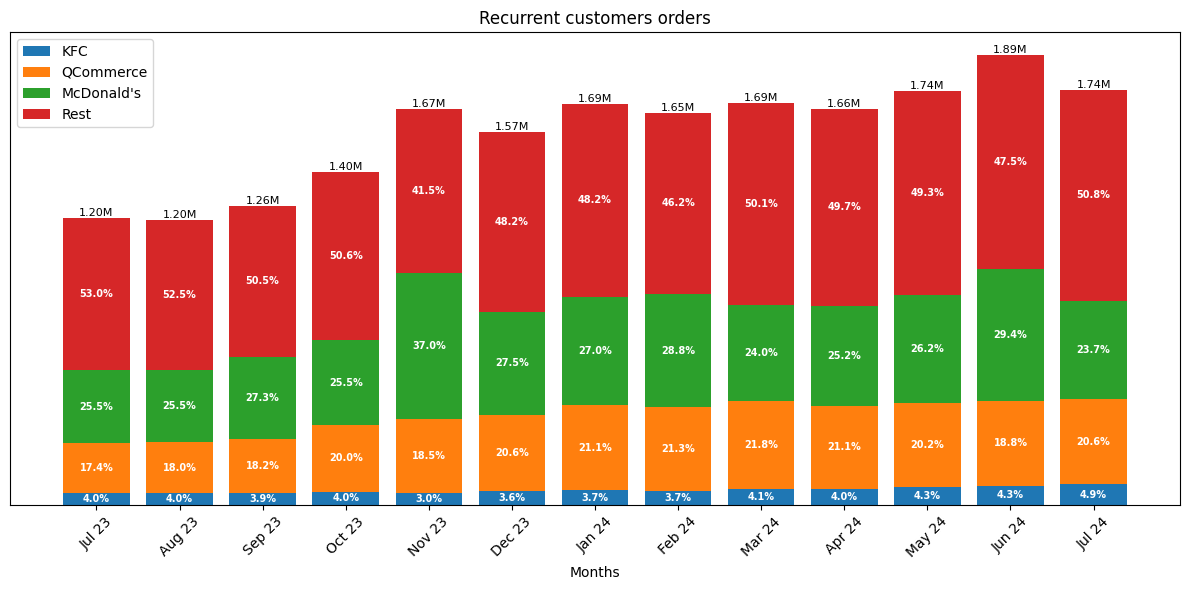

In [118]:
import matplotlib.pyplot as plt
import numpy as np


results = filter_and_count_rc_orders(loaded_recurrent_customers, loaded_orders, ["McDonald's",'KFC'], ['QCommerce'])

# Extracting the data
dates = list(results.keys())
months = [pd.to_datetime(date.split(' to ')[0]).strftime('%b %y') for date in dates]
totals = [results[date]['total'] for date in dates]

# Sort the data by dates in ascending order
sorted_indices = np.argsort([pd.to_datetime(date.split(' to ')[0]) for date in dates])
months = [months[i] for i in sorted_indices]
totals = [totals[i] for i in sorted_indices]
results = {dates[i]: results[dates[i]] for i in sorted_indices}

# Extracting categories dynamically
categories = set()
for value in results.values():
    categories.update(value.keys())
categories.discard('total')
categories.discard('rest')
categories = list(categories)

# Extracting values for each category
category_values = {category: [results[date].get(category, 0) for date in results.keys()] for category in categories}
rest = [results[date]['rest'] for date in results.keys()]

# Calculate percentages
category_percentages = {category: [value / total * 100 for value, total in zip(values, totals)] for category, values in category_values.items()}
rest_pct = [r / t * 100 for r, t in zip(rest, totals)]

# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Stacked bars
bottoms = np.zeros(len(dates))
bars = {}
for category in categories:
    bars[category] = ax.bar(months, category_values[category], bottom=bottoms, label=category)
    bottoms += category_values[category]

bars['rest'] = ax.bar(months, rest, bottom=bottoms, label='Rest')

# Adding labels and title
# ax.set_xlabel('Months')
ax.set_title('Recurrent customers orders')
ax.legend()

# Adding percentages inside the bars
def add_labels(bars, percentages):
    for bar, pct in zip(bars, percentages):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_y() + height / 2,
            f'{pct:.1f}%',
            ha='center',
            va='center',
            color='white',
            fontsize=7,
            fontweight='bold'
        )

for category in categories:
    add_labels(bars[category], category_percentages[category])
add_labels(bars['rest'], rest_pct)

# Adding total values on top of the bars
for i, total in enumerate(totals):
    ax.text(
        i,
        bottoms[i] + rest[i],
        f'{total/1e6:.2f}M',
        ha='center',
        va='bottom',
        fontsize=8,
        # fontweight='bold'
    )

# Remove y-axis
ax.yaxis.set_visible(False)

# Display the chart
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('final_chart_white_background.png')